# DeLIForest: Um detector de SPAMs via aprendizado supervisionado que supera abordagens precedentes

### Nome: André Luiz Moreira Dutra
### Matrícula: 2019006345

O problema da detecção de lixo eletrônico, os chamados "SPAMs", em caixas de entrada de serviços de mensagem, como emails e SMS, é de suma relevância no contexto de cibersegurança. Além de ocuparem o armazenamento dos serviços e obstruírem mensagens consideradas relevantes pelos usuários, as chamadas "HAMs", os SPAMs frequentemente carregam potenciais vulnerabilidades ao usuário na forma de links maliciosos e tentativas de golpes, sendo classificados no contexto de cibersegurança como vulnerabilidades de engenharia social. Neste contexto, diferentes trabalhos propuseram modelos de detectores de SPAM, em especial baseados em classificadores utilizando Aprendizado de Máquina supervisionado. Dentre eles, se destaca como um estudo de interesse um [modelo proposto por Ricardo Tombessi](https://www.kaggle.com/code/cdsegufmg/classificacao-spam), que propõe uma solução utilizando embeddings do tipo bag-of-words (CountVectorizer) e um modelo Naive Bayes Multimodal com acurácia superior a 90%. Desse modo, este trabalho propõe o DeLIForest, o Detector de Lixo eletrônico Indesejado baseado em Random Forest, que consiste em um classificador de SPAMs e HAMs também baseado em embeddings bag-of-words, porém utilizando uma base maior e um modelo de Random Forest otimizado, resultando em um modelo que supera a solução proposta em desempenho.

## A Base ExAIS_SPAM
A base do modelo original é a SMS Spam Collection Dataset, uma base contendo mais de 5.000 mensagens de texto em inglês classificadas como HAM ou SPAM, advindas de múltiplas fontes. A base está disponível em:

> https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

A partir disso, primeiramente vamos aumentar a nossa base de hams e spams e com isso permitir uma melhor classificação dos resultados. Para isso, à base original vamos adicionar dados da base ExAIS de mensagens de SMS, disponíveis em:

> https://github.com/AbayomiAlli/SMS-Spam-Dataset

A base contém mensagens enviadas e recebidas por 20 usuários, classificadas como ham ou spam, dentre outras informações.

O tratamento da base foi feito da seguinte forma:
1. Primeiro, os dados de todos os usuários foram unidos.
2. Em seguida, os dados das mensagens e da classificação em ham e spam foram selecionados, e os demais descartados.
3. Por fim, mensagens enviadas e classificadas como spam foram eliminadas dos dados.
   1. Isso foi feito pois elas correspondiam a respostas dos usuários a números de spam como "CANCEL", "STOP".
   2. Sendo assim, elas não correspondiam ao padrão de mensagens de spam que queremos detectar.

In [19]:
sms_exais = pd.read_csv("/kaggle/input/exais-sms-spam-dataset/ExAIS_SMS.csv")
sms_exais.sample(5)

,label,message
3546,spam,If you cannot find the brighter side of life p...
2225,spam,"Dear Valued Customer, Welcome to Airtel! The N..."
135,ham,70XXXXX653
4925,spam,Please call Buy GOtv Decoder + 1 Month GOtv Pl...
730,ham,TANKX 4 being a calumniator and besmirchous nd...


## A Nova Base

Vamos agora unir a base ExAIS à já utilizada e formar uma nova base mais robusta e com menor diferença entre hams e spams:

In [20]:
sms_uci = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding = "ISO-8859-1", usecols=[0,1], skiprows=1,
                      names=["label", "message"])

sms = pd.concat([sms_exais, sms_uci])
sms.label = sms.label.map({"ham":0, "spam":1})
sms.sample(5)

,label,message
2978,1,"Xmas Offer! Latest Motorola, SonyEricsson & No..."
1535,1,You have won a Nokia 7250i. This is what you g...
1269,0,"Tee hee. Off to lecture, cheery bye bye."
292,0,Oops. 4 got that bit.
2598,0,Pls reply


Observe como os novos dados têm uma proporção ligeiramente maior de spams que antes:

In [21]:
old_hams, old_spams = sms_uci.label.value_counts()
print('Proporção antiga de spams: {:.2f}%'.format(100*old_spams/(old_hams+old_spams)))

hams, spams = sms.label.value_counts()
print('Proporção nova de spams:   {:.2f}%'.format(100*spams/(hams+spams)))

Proporção antiga de spams: 13.41%
Proporção nova de spams:   27.42%


## Tratamento dos Dados
Vamos agora separar os dados em treino e teste e vetorizar os textos das mensagens:

In [22]:
features_train, features_test, labels_train, labels_test = train_test_split(sms.message, sms.label, test_size=0.2, random_state = 52)
couvec = CountVectorizer()
couvec.fit(features_train)
dtm_train = couvec.fit_transform(features_train)
dtm_test = couvec.transform(features_test)

## Treinamento e Teste dos Modelos
A seguinte função encapsula o treino e o teste que será feito em cada modelo.

Dado o modelo, os dados e treino e os dados de teste, ela:
  1. Treina o modelo
  2. Prediz os dados de teste
  3. Retorna a acurácia, precisão, recall e os vetores de precisões e recalls dos resultados do teste em relação às labels verdadeiras 


In [23]:
def train_test_spam(model, vectors_train, labels_train, vectors_test, labels_test):
    model.fit(vectors_train, labels_train)
    labels_pred = model.predict(vectors_test)
    
    accuracy  = metrics.accuracy_score(labels_test, labels_pred)
    precision = metrics.precision_score(labels_test, labels_pred)
    recall    = metrics.recall_score(labels_test, labels_pred)
    
    labels_prob = model.predict_proba(vectors_test)[:, 1]
    precisions_list, recalls_list, _ = metrics.precision_recall_curve(labels_test, labels_prob)
    
    return accuracy, precision, recall, precisions_list[:-1], recalls_list[:-1]

## Proposição de Um Novo Modelo e Comparação

Em seguida, vamos testar os modelos.
* Propomos como um melhor modelo o Random Forest, pois:
  * Sendo formado por árvores de decisão, ele se adapta bem a dados discretos, semelhante ao Naive Bayes.
  * A feature selection interna feita pelo modelo o torna robusto a features correlacionadas, redundantes ou irrelevante.
  * Isso é especialmente benéfico para os vetores esparsos utilizados nesta classificação
* Ele será treinado e testado em comparação ao modelo anterior, o Naive Bayes Multimodal, para os mesmos parâmetros

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

model_names = ['Naive Bayes', 'Random Forest']

models = [MultinomialNB(), RandomForestClassifier(random_state = 52)]

results = [train_test_spam(model, dtm_train, labels_train, dtm_test, labels_test) for model in models]

## Plot dos Resultados

Observe as métricas e as curvas de precisão x recall de cada modelo:

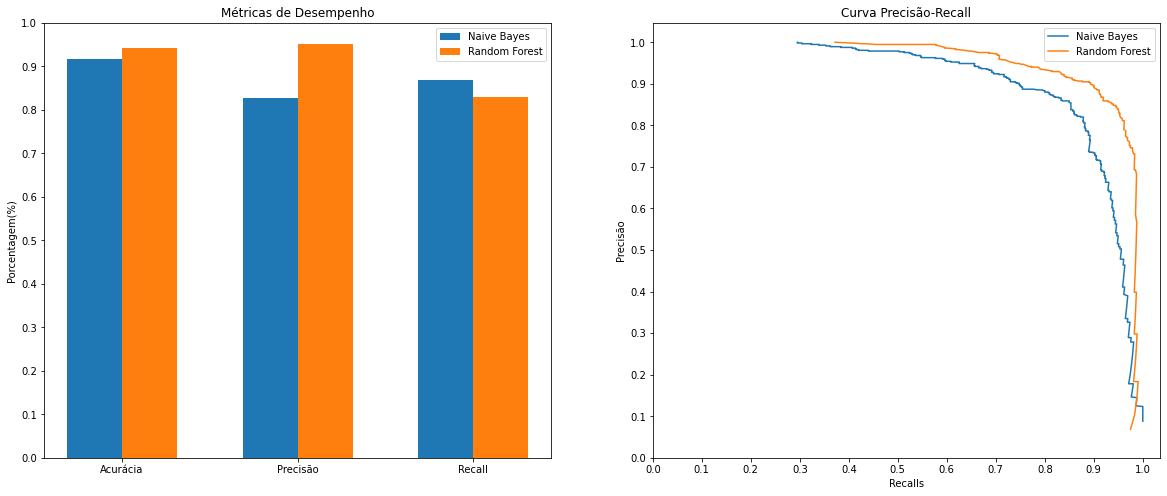

In [25]:
import matplotlib.pyplot as plt

models_num = len(models)

fig, axes = plt.subplots(1,2, figsize=(20,8))

bars_ax, curves_ax = axes

bar_width = 0.05
label_dist = 1.6*models_num*bar_width
bar_label_pos = np.arange(0, 3*label_dist, label_dist)

for idx, model_name, (accuracy, precision, recall, precisions_list, recalls_list) in zip(range(models_num), model_names, results):
    
    x = [pos - 0.5*(models_num-1)*bar_width + idx*bar_width for pos in bar_label_pos]
    y = [accuracy, precision, recall]
    bars_ax.bar(x, y, width = bar_width, label=model_name)
    
    curves_ax.plot(precisions_list, recalls_list, label=model_name)

bars_ax.set_xticks(bar_label_pos)
bars_ax.set_xticklabels(['Acurácia', 'Precisão', 'Recall'])
bars_ax.set_ylabel('Porcentagem(%)')
bars_ax.set_yticks(np.arange(0, 1.1, 0.1))
bars_ax.set_title('Métricas de Desempenho')
bars_ax.legend()

curves_ax.set_xlabel('Recalls')
curves_ax.set_ylabel('Precisão')
curves_ax.set_xticks(np.arange(0, 1.1, 0.1))
curves_ax.set_yticks(np.arange(0, 1.1, 0.1))
curves_ax.set_title('Curva Precisão-Recall')
curves_ax.legend()

fig.show()

## Análise dos Resultados

À esquerda, temos as métricas gerais dos modelos, e à direita temos a curva de precisão por revocação.

Primeiramente, é notável que o Random Forest superou o Naive Bayes tanto em acurácia geral quanto em precisão, tendo um resultado especialmente mais alto em precisão. A única métrica em que ele foi inferior foi a revocação, e mesmo nela a diferença não foi de menos de 5%.

É importante ressaltar que sabemos que existe um tradeoff entre precisão e recall e, para este problema específico, é interessante que a precisão seja mais relevante que o recall:

* Quanto maior a precisão, menor o número de falsos positivos, ou seja, mensagens de interesse (hams) sendo classificadas como spams.
* Quanto maior o recall, menor o número de falsos negativos, ou seja, spams sendo classificados como mensagens de interesse (hams).
* Uma maior precisão geralmente vem sob o custo de um menor recall e vice versa.

Para um usuário, o risco que um baixo recall oferece, que é o de que alguns spams ainda apareçam na caixa de mensagens, é muito menor que o risco que uma baixa precisão oferece, que é o de uma mensagem importante ser detectada como spam e descartada.

Nesse quesito, o Random Forest é superior ao Naive Bayes, que possui maior recall que precisão.

Observemos agora as curvas à direita. Elas representam o tradeoff da precisão pela revocação de cada modelo em diferentes thresholds. Desse modo, uma maior área debaixo da curva indica ambos precisão e recall altos relativamente no modelo. Observe como a curva do Random Forest se encontra completamente acima da curva do Naive Bayes, ficando abaixo apenas em alguns pontos mais à direita de extrema priorização do recall em relação à revocação. Isso demonstra que, na esmagadora maioria dos thresholds, o tradeoff de precisão por revocação do Random Forest é menor que o do Naive Bayes, indicando maiores valores para ambos no Random Forest mesmo considerando as classes desbalanceadas.

Com isso, é evidente que o Random Forest possui um desempenho geral superior ao Naive Bayes na classificação de hams e spams em mensagens de SMS. 